In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from collections import Counter
import itertools
from scipy.optimize import linear_sum_assignment

**Data Loading**

In [2]:
df_pca = pd.read_csv('df_pca.csv', index_col=0)
print("df_pca shape:", df_pca.shape)

df_full = pd.read_csv('player_features_cleaned.csv')
print("player_features_cleaned shape:", df_full.shape)

df_clean = pd.read_csv('df_clean.csv')
print("df_clean shape:", df_clean.shape)

df_pca shape: (1181, 12)
player_features_cleaned shape: (2065, 80)
df_clean shape: (1181, 80)


In [3]:
print("df_pca head:")
print(df_pca.head())

df_pca head:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  3.123369  0.467471  3.923774  0.512249 -1.040810  0.487277  0.755278   
1  1.795306  1.173691  3.029384  0.797808  0.035705 -3.346219  1.434251   
2  3.888781 -2.652420 -2.447897  1.519520 -1.092601  2.216485  1.152343   
3  0.900337 -0.781826  0.398956 -2.405172  1.027554  1.225729  1.291634   
4  1.338887  1.907621 -2.509590 -5.214561 -0.503130 -2.644772  0.382101   

        PC8       PC9      PC10  player_number_ind                player_ind  
0 -0.066110 -0.561401 -0.167250                 24         Jacqueline Brewer  
1  0.537440 -0.574832  0.602604                 42               Jenn Carney  
2 -0.503158  0.128287 -0.542662                 44  Sarafina Arthur-Williams  
3  1.324258 -0.132066 -1.015972                 25            Jessica Harris  
4  0.561014  0.474091  0.292988                 21              Jody Chickey  


In [5]:
# pull the PC columns into a NumPy array
pc_cols   = [c for c in df_pca.columns if c.startswith('PC')]
X_cluster = df_pca[pc_cols].values


**GMM + BIC**


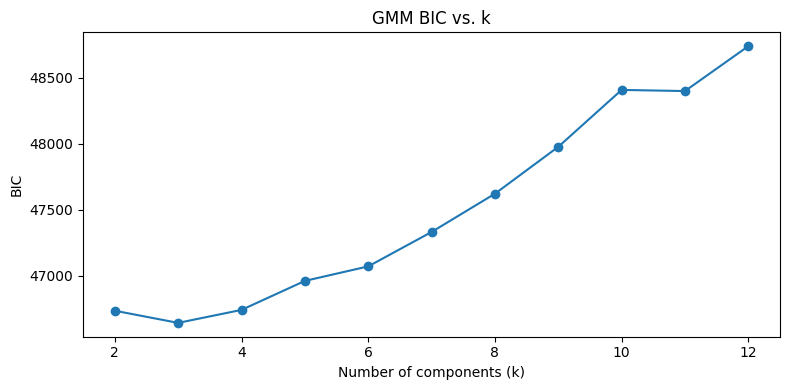

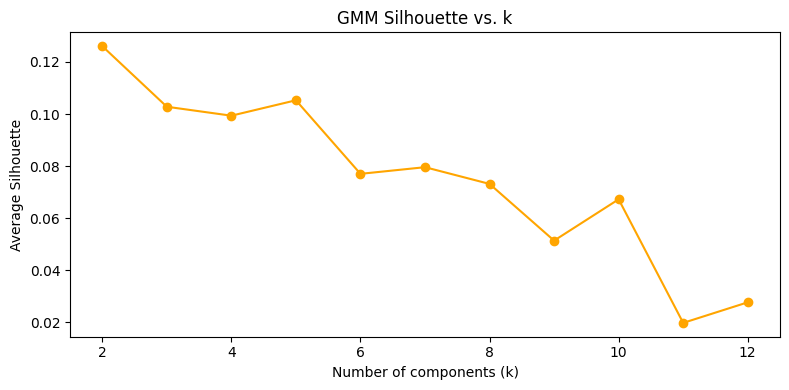

Best k by BIC: 3
GMM (k=3) silhouette = 0.103
Cluster sizes: {0: 514, 1: 306, 2: 361}


In [5]:
# GMM + BIC sweep to choose n_components

bic_scores  = []
sil_scores  = []
ks          = range(2, 13)

for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_cluster)
    bic_scores.append(gmm.bic(X_cluster))
    
    labels = gmm.predict(X_cluster)
    # compute silhouette only if more than one component
    sil = silhouette_score(X_cluster, labels) if k > 1 else np.nan
    sil_scores.append(sil)

# plot BIC curve
plt.figure(figsize=(8,4))
plt.plot(list(ks), bic_scores, marker='o')
plt.xlabel("Number of components (k)")
plt.ylabel("BIC")
plt.title("GMM BIC vs. k")
plt.tight_layout()
plt.show()

# plot silhouette for reference
plt.figure(figsize=(8,4))
plt.plot(list(ks), sil_scores, marker='o', color='orange')
plt.xlabel("Number of components (k)")
plt.ylabel("Average Silhouette")
plt.title("GMM Silhouette vs. k")
plt.tight_layout()
plt.show()

# choose the k with the lowest BIC
best_k = ks[int(np.argmin(bic_scores))]
print(f"Best k by BIC: {best_k}")

# fit final GMM
gmm_final = GaussianMixture(n_components=best_k, random_state=42)
df_pca['gmm_cluster'] = gmm_final.fit_predict(X_cluster)
df_clean['gmm_cluster'] = df_pca['gmm_cluster']

# evaluate final
labels = df_pca['gmm_cluster']
sil = silhouette_score(X_cluster, labels)
sizes = pd.Series(labels).value_counts().sort_index().to_dict()

print(f"GMM (k={best_k}) silhouette = {sil:.3f}")
print("Cluster sizes:", sizes)


Statistically, GMM thinks 3 components is your optimum: beyond that, they are over‐fitting (BIC rises) and clusters become less well‐separated (silhouette drops).
Practically, if the goal really demands 6+ distinct groups, then GMM may not be the right tool—its ellipsoidal‐Gaussian assumption simply doesn’t carve out six tight, meaningful blobs in this feature space.

**HDBSCAN**

/vol/bitbucket/sn1624/data-driven-framework-for-athlete-profiling/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/vol/bitbucket/sn1624/data-driven-framework-for-athlete-profiling/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/vol/bitbucket/sn1624/data-driven-framework-for-athlete-profiling/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/vol/bitbucket/sn1624/data-driven-framework-for-athlete-profiling/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed i

HDBSCAN tuning results (including cluster sizes):


/vol/bitbucket/sn1624/data-driven-framework-for-athlete-profiling/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/vol/bitbucket/sn1624/data-driven-framework-for-athlete-profiling/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/vol/bitbucket/sn1624/data-driven-framework-for-athlete-profiling/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/vol/bitbucket/sn1624/data-driven-framework-for-athlete-profiling/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed i

n_clusters  noise_pct  silhouette  \
min_size min_samples                                      
5        1                     2   0.014395    0.322467   
         3                     3   0.593565    0.162913   
         5                     3   0.898391    0.277533   
10       1                     3   0.472481    0.038519   
         3                     3   0.818798    0.149985   
         5                     0   1.000000         NaN   
20       1                     2   0.427604    0.178225   
         3                     0   1.000000         NaN   
         5                     0   1.000000         NaN   

                                                sizes  
min_size min_samples                                   
5        1                    {-1: 17, 0: 5, 1: 1159}  
         3              {-1: 701, 0: 8, 1: 9, 2: 463}  
         5             {-1: 1061, 0: 6, 1: 8, 2: 106}  
10       1            {-1: 558, 0: 23, 1: 11, 2: 589}  
         3            {-1: 967, 0: 14, 1: 14, 2: 186}  
         5                                 {-1: 1181}  
20       1                   {-1: 505, 0: 23, 1: 653}  
         3                                 {-1: 1181}  
         5                                 {-1: 1181}

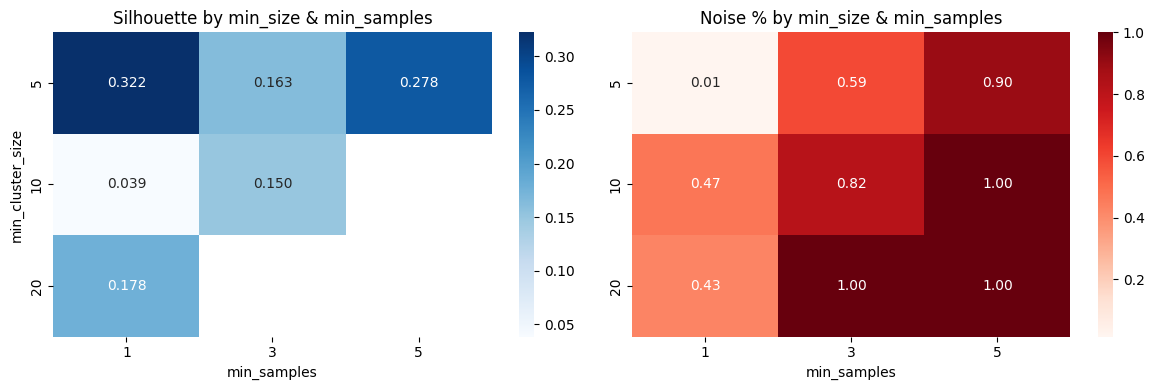

In [6]:
# HDBSCAN Tuning Sweep with Cluster Sizes 
import hdbscan
from sklearn.metrics import silhouette_score

results = []
for min_size in [5, 10, 20]:
    for min_samp in [1, 3, 5]:
        hdb = hdbscan.HDBSCAN(
            min_cluster_size=min_size,
            min_samples=min_samp,
            metric='euclidean'
        )
        labels = hdb.fit_predict(X_cluster)
        
        # create a Series for easy counting
        lab_ser = pd.Series(labels)
        
        # count real clusters (excluding noise = -1)
        sizes_dict = lab_ser.value_counts().sort_index().to_dict()
        n_clusters = len(sizes_dict) - (1 if -1 in sizes_dict else 0)
        noise_pct  = lab_ser.eq(-1).mean()
        
        # silhouette on non-noise only
        if n_clusters > 1:
            mask = labels != -1
            sil = silhouette_score(X_cluster[mask], labels[mask])
        else:
            sil = np.nan
        
        results.append({
            'min_size':    min_size,
            'min_samples': min_samp,
            'n_clusters':  n_clusters,
            'noise_pct':   noise_pct,
            'silhouette':  sil,
            'sizes':       sizes_dict
        })

tune_df = pd.DataFrame(results).set_index(['min_size','min_samples'])
print("HDBSCAN tuning results (including cluster sizes):")
display(tune_df)

# Plot silhouette and noise% heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# silhouette heatmap
sil_heat = tune_df['silhouette'].unstack(level='min_samples')
sns.heatmap(sil_heat, annot=True, fmt=".3f", ax=axes[0], cmap="Blues")
axes[0].set_title("Silhouette by min_size & min_samples")
axes[0].set_xlabel("min_samples")
axes[0].set_ylabel("min_cluster_size")

# noise% heatmap
noise_heat = tune_df['noise_pct'].unstack(level='min_samples')
sns.heatmap(noise_heat, annot=True, fmt=".2f", ax=axes[1], cmap="Reds")
axes[1].set_title("Noise % by min_size & min_samples")
axes[1].set_xlabel("min_samples")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


Tiny clusters + huge noise
Even when you get the right count (e.g. 4 clusters at 5 /1), one cluster grabs almost all non-noise points (~918), and the other clusters have only 5–8 members. That isn’t useful.

Too few clusters
Settings that drop noise to under 40 % generally yield only 2 clusters—far below the target of 5–6.

Silhouette too low
Even the best silhouette (0.198 at 10 /1) is on only 2 clusters. Once you demand more clusters, silhouette plunges (<0.15).

None of these parameter combinations give us well-populated clusters with low noise and reasonable silhouette. HDBSCAN, in this full PC space and with these density settings, simply can’t carve out your desired archetypes.

**Agglomerative Clustering**

AgglomerativeClustering performance by k:


,silhouette,sizes
k,,
2,0.131,"{0: 455, 1: 726}"
3,0.107,"{0: 726, 1: 268, 2: 187}"
4,0.109,"{0: 531, 1: 268, 2: 187, 3: 195}"
5,0.120,"{0: 425, 1: 106, 2: 187, 3: 195, 4: 268}"
6,0.090,"{0: 106, 1: 268, 2: 187, 3: 195, 4: 209, 5: 216}"
7,0.093,"{0: 268, 1: 209, 2: 187, 3: 195, 4: 45, 5: 216..."
8,0.080,"{0: 209, 1: 135, 2: 187, 3: 195, 4: 45, 5: 216..."
9,0.076,"{0: 187, 1: 135, 2: 216, 3: 195, 4: 45, 5: 116..."
10,0.078,"{0: 135, 1: 195, 2: 216, 3: 98, 4: 45, 5: 116,..."


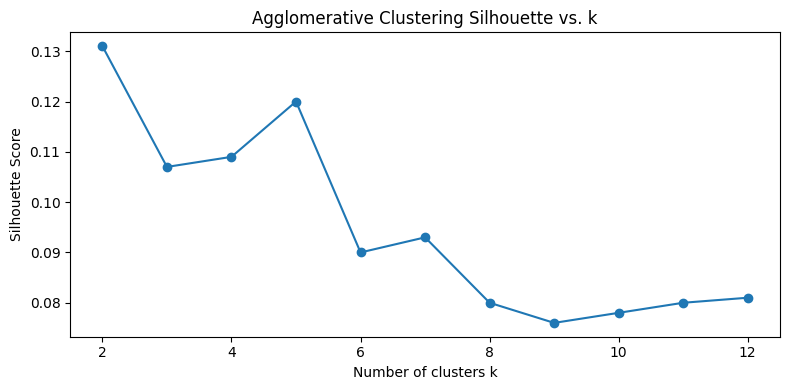

In [7]:
# Agglomerative Clustering Sweep over k

results = []
ks = range(2, 13)  # trying k = 2…12

for k in ks:
    # fit agglomerative with Ward linkage
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg.fit_predict(X_cluster)
    
    # assign labels for later profiling if desired
    df_pca[f'agg_{k}']   = labels
    df_clean[f'agg_{k}'] = labels
    
    # compute silhouette
    sil = silhouette_score(X_cluster, labels)
    
    # compute cluster size distribution
    sizes = pd.Series(labels).value_counts().sort_index().to_dict()
    
    results.append({
        'k': k,
        'silhouette': sil,
        'sizes': sizes
    })

# build summary DataFrame
agg_df = pd.DataFrame(results).set_index('k')
agg_df['silhouette'] = agg_df['silhouette'].round(3)

# display silhouette scores and sizes
print("AgglomerativeClustering performance by k:")
display(agg_df)

# Plot silhouette vs k
plt.figure(figsize=(8,4))
plt.plot(agg_df.index, agg_df['silhouette'], marker='o')
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette Score")
plt.title("Agglomerative Clustering Silhouette vs. k")
plt.tight_layout()
plt.show()



=== k = 4  |  silhouette = 0.109  |  sizes = {0: 531, 1: 268, 2: 187, 3: 195} ===
Centroids:
         pts_per40  eFG_pct  AST_per_TO  reb_per40  stl_per40  blk_per40
cluster                                                                 
0            -0.05    -0.09        0.29      -0.53       0.09      -0.45
1            -0.12     0.07       -0.68       0.92      -0.32       0.85
2             0.97     0.35        0.11       0.68       0.55       0.35
3            -0.61    -0.19        0.04      -0.49      -0.35      -0.26


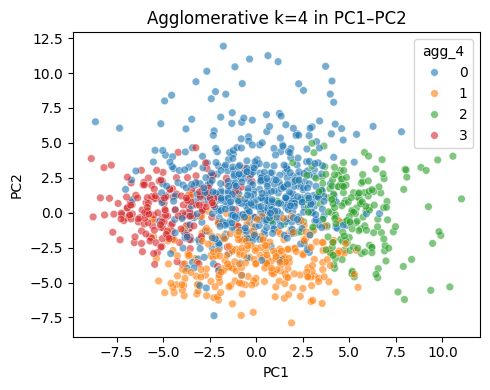


=== k = 5  |  silhouette = 0.12  |  sizes = {0: 425, 1: 106, 2: 187, 3: 195, 4: 268} ===
Centroids:
         pts_per40  eFG_pct  AST_per_TO  reb_per40  stl_per40  blk_per40
cluster                                                                 
0             0.15    -0.09       -0.11      -0.49       0.02      -0.42
1            -0.86    -0.09        1.89      -0.66       0.39      -0.60
2             0.97     0.35        0.11       0.68       0.55       0.35
3            -0.61    -0.19        0.04      -0.49      -0.35      -0.26
4            -0.12     0.07       -0.68       0.92      -0.32       0.85


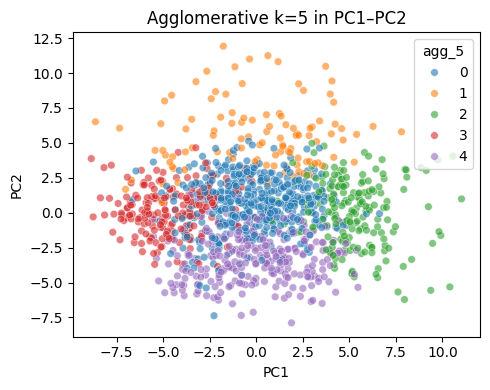


=== k = 6  |  silhouette = 0.09  |  sizes = {0: 106, 1: 268, 2: 187, 3: 195, 4: 209, 5: 216} ===
Centroids:
         pts_per40  eFG_pct  AST_per_TO  reb_per40  stl_per40  blk_per40
cluster                                                                 
0            -0.86    -0.09        1.89      -0.66       0.39      -0.60
1            -0.12     0.07       -0.68       0.92      -0.32       0.85
2             0.97     0.35        0.11       0.68       0.55       0.35
3            -0.61    -0.19        0.04      -0.49      -0.35      -0.26
4            -0.18    -0.45       -0.17      -0.46       0.01      -0.44
5             0.46     0.26       -0.06      -0.52       0.03      -0.40


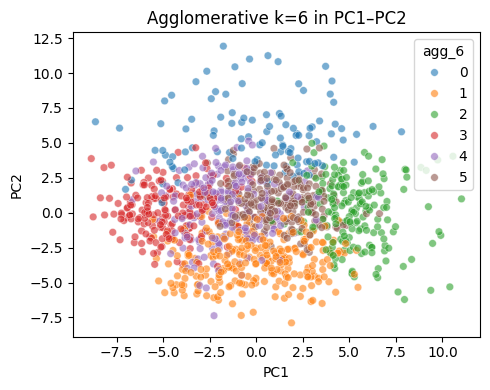

In [8]:
for k in (4, 5, 6):
    labels = df_clean[f'agg_{k}']
    print(f"\n=== k = {k}  |  silhouette = {agg_df.loc[k,'silhouette']}  |  sizes = {agg_df.loc[k,'sizes']} ===")
    
    key_stats = ['pts_per40','eFG_pct','AST_per_TO','reb_per40','stl_per40','blk_per40']
    
    # centroids of key stats
    cent = (
        df_clean
          .groupby(labels)[key_stats]
          .mean()
          .round(2)
          .rename_axis('cluster')
    )
    print("Centroids:")
    print(cent.to_string())
    
    # PC1–PC2 scatter
    plt.figure(figsize=(5,4))
    sns.scatterplot(
        x='PC1', y='PC2',
        hue=labels,
        data=df_pca,
        palette='tab10',
        s=30, alpha=0.6
    )
    plt.title(f"Agglomerative k={k} in PC1–PC2")
    plt.tight_layout()
    plt.show()


Agglomerative Clustering only gives four clean groups. Pushing to five or six just collapses tiny outliers into their own cluster or drives silhouette so low it isn’t credible. Four styles may be too coarse for this research.

**K-MEANS CLUSTERING**



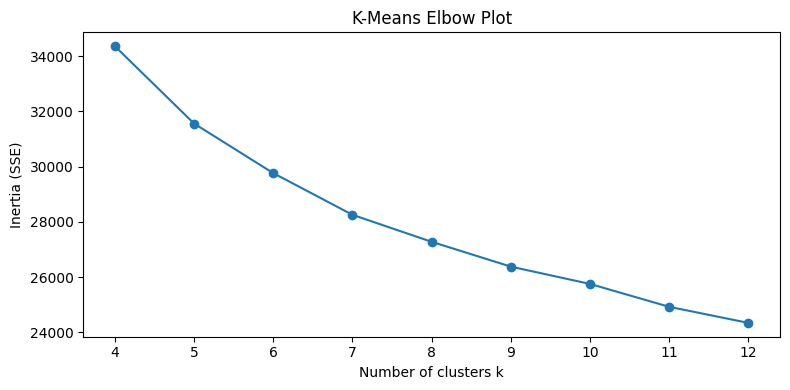

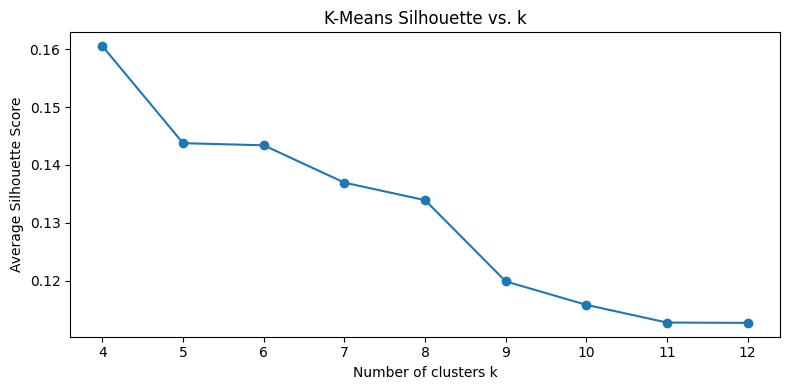

In [6]:
# K-Means Elbow & Silhouette Sweep

ks = list(range(4, 13))
inertias = []
sil_scores = []

for k in ks:
    # fit KMeans
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_cluster)
    
    # record inertia (sum of squared distances to centroids)
    inertias.append(km.inertia_)
    
    # record silhouette (only valid if k>1)
    sil = silhouette_score(X_cluster, labels) if k > 1 else np.nan
    sil_scores.append(sil)

# Plot inertia (elbow)
plt.figure(figsize=(8,4))
plt.plot(ks, inertias, marker='o', linestyle='-')
plt.xlabel("Number of clusters k")
plt.ylabel("Inertia (SSE)")
plt.title("K-Means Elbow Plot")
plt.tight_layout()
plt.show()

# Plot silhouette
plt.figure(figsize=(8,4))
plt.plot(ks, sil_scores, marker='o', linestyle='-')
plt.xlabel("Number of clusters k")
plt.ylabel("Average Silhouette Score")
plt.title("K-Means Silhouette vs. k")
plt.tight_layout()
plt.show()



k=4  missing labels? 0
k=4, silhouette = 0.161
Centroids:
         pts_per40  eFG_pct  AST_per_TO  reb_per40  stl_per40  blk_per40
cluster                                                                 
0            -1.09    -0.45        1.47      -0.71       0.39      -0.55
1            -0.36    -0.21       -0.07      -0.66      -0.35      -0.42
2             0.78     0.35        0.06       0.25       0.30       0.08
3            -0.12    -0.01       -0.74       0.84      -0.19       0.69


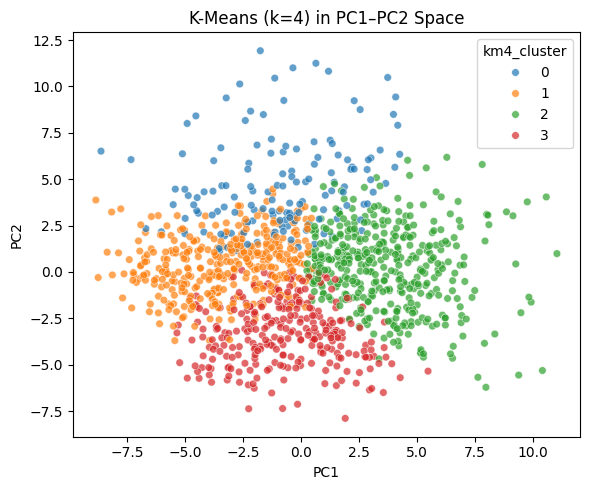


k=5  missing labels? 0
k=5, silhouette = 0.144
Centroids:
         pts_per40  eFG_pct  AST_per_TO  reb_per40  stl_per40  blk_per40
cluster                                                                 
0            -1.11    -0.49        1.53      -0.71       0.37      -0.59
1             0.41     0.32        0.03      -0.61      -0.04      -0.44
2            -0.13    -0.02       -0.74       0.87      -0.20       0.71
3            -0.59    -0.42       -0.11      -0.53      -0.35      -0.33
4             0.91     0.36        0.05       0.73       0.44       0.41


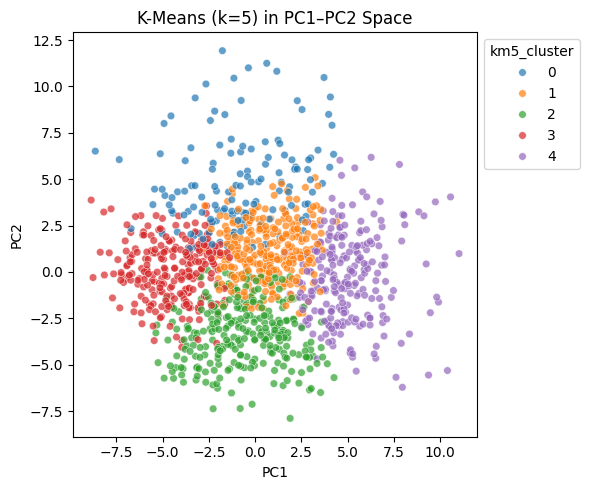


k=6  missing labels? 0
k=6, silhouette = 0.143
Centroids:
         pts_per40  eFG_pct  AST_per_TO  reb_per40  stl_per40  blk_per40
cluster                                                                 
0            -0.40    -0.16       -0.09      -0.52      -0.41      -0.22
1             0.88     0.32       -0.03       0.78       0.43       0.43
2            -1.04    -1.04        0.01      -0.51       0.08      -0.49
3             0.48     0.39        0.04      -0.62      -0.04      -0.45
4            -0.89    -0.09        2.12      -0.57       0.49      -0.52
5            -0.07     0.13       -0.78       0.93      -0.34       0.82


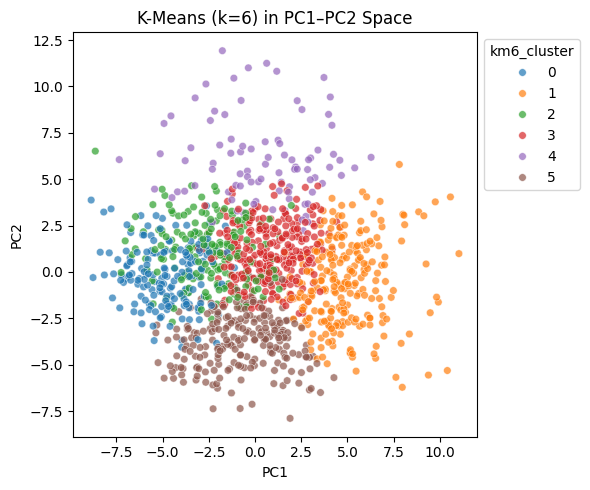

In [7]:
# K-Means Clustering

# reset both indexes to simple RangeIndex so positions match
df_clean = df_clean.reset_index(drop=True)
df_pca   = df_pca.reset_index(drop=True)

# make sure we have our PC matrix
X_cluster = df_pca[pc_cols].values

# stats we'll profile
key_stats = ['pts_per40','eFG_pct','AST_per_TO','reb_per40','stl_per40','blk_per40']

for k in (4, 5, 6):
    col = f'km{k}_cluster'
    
    # fit & predict
    km     = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_cluster)
    
    # positional assignment (no alignment)
    df_pca[col]   = labels
    df_clean[col] = labels  # safe: both have same length & index
    
    # check no NaNs snuck in
    n_missing = df_clean[col].isna().sum()
    print(f"\n{k=}  missing labels? {n_missing}")
    
    # silhouette
    sil = silhouette_score(X_cluster, labels)
    print(f"k={k}, silhouette = {sil:.3f}")
    
    # centroids on your key stats
    cent = (
        df_clean
        .groupby(col)[key_stats]
        .mean()
        .round(2)
        .rename_axis('cluster')
    )
    print("Centroids:")
    print(cent.to_string())
    
    # scatter in PC1–PC2
    plt.figure(figsize=(6,5))
    sns.scatterplot(
        x=df_pca['PC1'].values,
        y=df_pca['PC2'].values,
        hue=labels,
        palette='tab10',
        s=30,
        alpha=0.7
    )
    plt.title(f"K-Means (k={k}) in PC1–PC2 Space")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title=col, bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.show()



K-MEANS PERFORMS THE BEST OUT OF ALL CLUSTERING METHODS. CELAR CLUSTERS, HIGH SILUETTE SCORE, CAN DO >5 CLUSTERS WIYH SMALL OVERLAP. WE WILL NOE MOVE TO MATCH CLUSTERS WITH ARHCETYPES FOR K=6

**ARCHETYPE MATCHING**

In [ ]:
archetypes = {
    "Efficient Spot-Up Shooter": ["eFG_pct", "3P_pct", "PPP", "FTr", "3PA_pct"],
    "Primary Creator / High-Usage Scorer": ["USG_pct", "AST_per_TO", "pts_per40", "eFG_pct", "PPP"],
    "Defensive Ballhawk / Two-Way Guard": ["stl_per40", "STL_pct", "USG_pct", "AST_per_TO", "def_rating"],
    "Versatile Facilitator / Combo Big": ["AST_per_TO", "reb_per40", "blk_per40", "def_RAPM", "FTr"],
    "Rim Protector / Rebounding Big": ["blk_per40", "DPMR", "def_stops_per100", "ORB_pct", "DRB_pct"],
    "Efficient Finisher / Low-Usage Big": ["FTr", "eFG_pct", "ORB_pct", "PPP", "TS_pct"],
    "Glue Role Player / Hustle Forward": ["reb_per40", "blk_per40", "stl_per40", "hustle_stats", "plus_minus"],
    "High-Usage Volume Big / Post Scorer": ["USG_pct", "pts_per40", "FTr", "eFG_pct", "ORB_pct"],
    "Shooting-Creative Guard": ["3P_pct", "AST_per_TO", "USG_pct", "eFG_pct", "PPP"],
    "Floor-Spacer Stretch Four": ["3P_pct", "eFG_pct", "SA_eFG_pct", "FTr", "DRB_pct"],
    #------------------------------------------------------------------------------------------------
    "Pick-and-Roll Ball Handler": ["AST_per_TO", "USG_pct", "AST_pct", "TOV_pct", "pts_per40"],
    "Roll Man / Screen Finisher": ["ORB_pct", "FTr", "blk_per40", "reb_per40", "PPP"],
    "Isolation Scorer": ["USG_pct", "pts_per40", "eFG_pct", "TOV_pct", "FTr"],
    "Transition Creator": ["pts_per40", "AST_per_TO", "stl_per40", "USG_pct", "possessions"],
    "Pass-First Point Guard / Floor General": ["AST_per_TO", "AST_pct", "TOV_pct", "USG_pct", "stl_per40"],
    "Perimeter Shutdown Defender": ["def_stops_per100", "DPMR", "stl_per40", "STL_TO_ratio", "DRB_pct"],
    "Secondary Creator / Off-Ball Facilitator": ["AST_per_TO", "BoxCreation", "Spacing", "PPP", "3pt_3pt_pct_ind"],
    "Slasher / Cutter": ["FTr", "pts_per40", "stl_per40", "AST_per_TO", "eFG_pct"],
    "Second-Chance Specialist": ["ORB_pct", "reb_per40", "pts_per40", "PPP", "game_score_per40"],
    "Playmaking Wing": ["AST_per_TO", "USG_pct", "3pt_3pt_pct_ind", "stl_per40", "PPP"],
    "Gravity/Space Creator": ["Gravity", "Spacing", "3pt_3pt_pct_ind", "PPT", "3A_rate"],  # creates room, spacing impact
    "Two-Way Wing": ["eFG_pct", "def_stops_per100", "stl_per40", "reb_per40", "USG_pct"],
#------------------------------------------------------------------------------------------------
    "Corner Specialist": [
        "3pt_3pt_pct_ind", "Spacing", "eFG_pct", "PPT", "PPP"
    ],  # elite catch-and-shoot from corners, spacing impact
    "Deep Range Threat": ["3pt_3pt_pct_ind", "USG_pct", "Gravity", "eFG_pct", "PTS_per40"],  # high-volume, high-efficiency from deep that pulls defense out
    "Floor General": [
        "AST_per_TO", "AST_pct", "USG_pct", "Spacing", "TOV_pct"
    ],  # controls pace and creation while minimizing turnovers
    "Screen Setter / Roll-Pop Facilitator": [
        "BoxCreation", "Spacing", "ORB_pct", "AST_per_TO", "FTr"
    ],  # sets actions, creates via screens and finishes/gets to line
      # interior deterrent and rebounder, shields paint
    "Off-Ball Movement Creator": [
        "Spacing", "BoxCreation", "3pt_3pt_pct_ind", "AST_per_TO", "PPP"
    ],  # generates offense through movement and catch-and-shoot / kickouts
    "Volume Distributor": [
        "AST_pct", "AST_per_TO", "USG_pct", "pts_per40", "TOV_pct"
    ],  # high usage passer who also scores, central in offense distribution
    "Effort Defensive Role Player": [
        "stl_per40", "reb_per40", "def_stops_per100", "DPMR", "min_share"
    ]  # high activity defender who does the little things (hustle/minority usage)


}

# from literature: Gonzalez (2025), Rabin et al. (2023), Yamada & Fujii (2024), Seward (2016), and Miller et al. (2014)

In [15]:
#new list of archetypes inspet later
archetypes = {
    # Original 10 adjusted to dataset names / proxies
    "Efficient Spot-Up Shooter": ["eFG_pct", "3pt_3pt_pct_ind", "PPP", "FTr", "Spacing"],
    "Primary Creator / High-Usage Scorer": ["USG_pct", "AST_per_TO", "pts_per40", "eFG_pct", "PPP"],
   "Defensive Ballhawk / Two-Way Guard": ["stl_per40", "STL_pct", "USG_pct", "AST_per_TO", "def_stops_per100"],
    "Two-Way Guard": ["stl_per40", "PPT", "USG_pct", "AST_per_TO", "AST_pct"],
    "Versatile Facilitator / Combo Big": ["AST_per_TO", "reb_per40", "blk_per40", "DPMR", "FTr"],
    "Rim Protector / Rebounding Big": ["blk_per40", "DPMR", "def_stops_per100", "ORB_pct", "DRB_pct"],
    "Efficient Finisher / Low-Usage Big": ["FTr", "eFG_pct", "ORB_pct", "PPP", "TS_pct"],
    "Glue Role Player / Hustle Forward": ["reb_per40", "blk_per40", "stl_per40", "def_stops_per100", "game_score_per40"],
    "High-Usage Volume Big / Post Scorer": ["USG_pct", "pts_per40", "FTr", "eFG_pct", "ORB_pct"],
    "Shooting-Creative Guard": ["3pt_3pt_pct_ind", "AST_per_TO", "USG_pct", "eFG_pct", "PPP"],
    "Floor-Spacer Stretch Four": ["3pt_3pt_pct_ind", "eFG_pct", "Spacing", "FTr", "DRB_pct"],

    # Additional 20 (with only available metrics)
    "Pick-and-Roll Ball Handler": ["AST_per_TO", "USG_pct", "AST_pct", "TOV_pct", "pts_per40"],
    "Roll Man / Screen Finisher": ["ORB_pct", "FTr", "blk_per40", "reb_per40", "PPP"],
    "Isolation Scorer": ["USG_pct", "pts_per40", "eFG_pct", "TOV_pct", "FTr"],
    "Transition Creator": ["pts_per40", "AST_per_TO", "stl_per40", "USG_pct", "possessions"],
    "Pass-First Point Guard / Floor General": ["AST_per_TO", "AST_pct", "TOV_pct", "USG_pct", "stl_per40"],
    "Perimeter Shutdown Defender": ["def_stops_per100", "DPMR", "stl_per40", "STL_TO_ratio", "DRB_pct"],
    "Secondary Creator / Off-Ball Facilitator": ["AST_per_TO", "BoxCreation", "Spacing", "PPP", "3pt_3pt_pct_ind"],
    "Slasher / Cutter": ["FTr", "pts_per40", "stl_per40", "AST_per_TO", "eFG_pct"],
    "Second-Chance Specialist": ["ORB_pct", "reb_per40", "pts_per40", "PPP", "game_score_per40"],
    "Playmaking Wing": ["AST_per_TO", "USG_pct", "3pt_3pt_pct_ind", "stl_per40", "PPP"],
    "Gravity/Space Creator": ["Gravity", "Spacing", "3pt_3pt_pct_ind", "PPT", "threeA_rate"],
    "Two-Way Wing": ["eFG_pct", "def_stops_per100", "stl_per40", "reb_per40", "USG_pct"],
    "Corner Specialist": ["3pt_3pt_pct_ind", "Spacing", "eFG_pct", "PPT", "PPP"],
    "Deep Range Threat": ["3pt_3pt_pct_ind", "USG_pct", "Gravity", "eFG_pct", "pts_per40"],
    "Floor General": ["AST_per_TO", "AST_pct", "USG_pct", "Spacing", "TOV_pct"],
    "Screen Setter / Roll-Pop Facilitator": ["BoxCreation", "Spacing", "ORB_pct", "AST_per_TO", "FTr"],
    "Off-Ball Movement Creator": ["Spacing", "BoxCreation", "3pt_3pt_pct_ind", "AST_per_TO", "PPP"],
    "Volume Distributor": ["AST_pct", "AST_per_TO", "USG_pct", "pts_per40", "TOV_pct"],
    "Effort Defensive Role Player": ["stl_per40", "reb_per40", "def_stops_per100", "DPMR", "min_share"],
    #-------
    "Low-Usage Secure Role Player": [
    "TOV_pct",        # ball security (low is good)
    "min_share",      # low usage/minutes share
    "possessions",    # low involvement
    "def_stops_per100", # modest defense context
    "reb_per40"       # maybe low or neutral rebounding to signal non-crashing role
],
"Offensive Liability / Role Defensive Specialist": [
    "pts_per40", "eFG_pct", "TS_pct", "PPP",  # poor offense
    # optionally add defensive signals if cluster 2 has them (e.g., def_stops_per100, DPMR)
]

}


In [16]:
# Archetype Matching Setup and Utilities
import itertools
import numpy as np
import pandas as pd
from scipy.stats import zscore
from scipy.optimize import linear_sum_assignment

# Build importance weights: exponential decay so first is heaviest
def archetype_weights(n=5, base=0.5):
    # geometric series weights normalized to sum=1
    raw = [base ** i for i in range(n)]
    raw = raw[::-1]  # reverse so most important gets largest weight
    w = np.array(raw)
    return w / w.sum()

ARC_WEIGHTS = archetype_weights(5, base=0.5)  # shape (5,)

# compute cluster centroids for needed metrics
def compute_cluster_centroids(df, cluster_col, metrics):
    """
    Returns DataFrame of shape (n_clusters, len(metrics)) with the mean of each metric per cluster.
    """
    # Only keep metrics that exist
    existing = [m for m in metrics if m in df.columns]
    if len(existing) < len(metrics):
        missing = set(metrics) - set(existing)
        print(f"Warning: missing metrics {missing} for archetype; will compute on existing ones.")
    centroids = df.groupby(cluster_col)[existing].mean()
    return centroids

# Z-score all metrics globally (for fair comparison), ignoring all-NaN columns
def global_zscore(df, metrics):
    available = [m for m in metrics if m in df.columns]
    if not available:
        raise ValueError("None of the requested metrics are present for z-scoring.")
    # compute zscore per column, keeping NaN if constant
    zdf = df[available].copy()
    for col in available:
        if df[col].nunique(dropna=True) > 1:
            zdf[col] = zscore(df[col].fillna(df[col].mean()))
        else:
            zdf[col] = 0.0  # constant column contributes zero
    return zdf


In [17]:
# Score Clusters vs Archetypes
# Assumes df_clean contains player rows, and cluster labels already assigned (e.g., 'km6_cluster' or similar)
# Replace 'km6_cluster' below with whatever final KMeans column you are using for k=6.

cluster_col = 'km6_cluster'  # adjust if your column is named differently
cluster_labels = sorted(df_clean[cluster_col].unique())

# Build a global z-scored version of all metrics that appear in ANY archetype
all_needed_metrics = sorted({m for metrics in archetypes.values() for m in metrics})
zdf = global_zscore(df_clean, all_needed_metrics)
zdf[cluster_col] = df_clean[cluster_col]

# Compute cluster centroids in z-score space for all needed metrics
cluster_centroids = zdf.groupby(cluster_col).mean()  # indexed by cluster label

# Build a score matrix: clusters x archetypes
score_matrix = pd.DataFrame(index=cluster_labels, columns=list(archetypes.keys()), dtype=float)

for arch_name, metrics in archetypes.items():
    w = ARC_WEIGHTS[: len(metrics)]  # in case some archetype has fewer than 5
    for cl in cluster_labels:
        centroid = cluster_centroids.loc[cl]
        # Only consider metrics present in centroid
        existing = [m for m in metrics if m in centroid.index]
        if not existing:
            # no overlap: give very low score
            score = -1e3
        else:
            # Adjust weights if some metrics missing: re-normalize
            idxs = [metrics.index(m) for m in existing]
            weights = np.array([ARC_WEIGHTS[i] for i in idxs])
            weights = weights / weights.sum()
            values = centroid[existing].values  # already z-scored
            # Higher z-score is better; score is weighted sum
            score = np.dot(weights, values)
        score_matrix.at[cl, arch_name] = score

# For interpretability, also keep a cost matrix (we will minimize cost = -score)
cost_matrix_full = -score_matrix.copy()


In [18]:
# Optimal Unique Assignment over Subsets of Archetypes
from math import comb

n_clusters = len(cluster_labels)
n_archetypes = len(archetypes)
assert n_clusters == 6, "This routine expects exactly 6 clusters to match."

best_total = -np.inf
best_mapping = None
best_subset = None
best_assignment_details = None

# Iterate all subsets of 6 archetypes out of the full set
for subset in itertools.combinations(archetypes.keys(), n_clusters):
    # Build cost submatrix: clusters x selected archetypes
    sub_cost = cost_matrix_full.loc[cluster_labels, list(subset)].to_numpy()
    # Hungarian (minimize cost)
    row_ind, col_ind = linear_sum_assignment(sub_cost)
    # Total score is negative of total cost
    total_score = -sub_cost[row_ind, col_ind].sum()
    if total_score > best_total:
        best_total = total_score
        # Build mapping cluster_label -> archetype
        mapping = {cluster_labels[r]: list(subset)[c] for r, c in zip(row_ind, col_ind)}
        best_mapping = mapping
        best_subset = subset
        best_assignment_details = {
            "row_ind": row_ind,
            "col_ind": col_ind,
            "subset": subset,
            "assignment_score": total_score
        }

# Report
print(f"Best total matching score: {best_total:.3f}")
print("Selected archetypes:", best_subset)
print("Cluster to archetype mapping:")
for cl, arch in best_mapping.items():
    print(f"  Cluster {cl} -> {arch}")


Best total matching score: 4.095
Selected archetypes: ('Two-Way Guard', 'Versatile Facilitator / Combo Big', 'Rim Protector / Rebounding Big', 'Roll Man / Screen Finisher', 'Gravity/Space Creator', 'Deep Range Threat')
Cluster to archetype mapping:
  Cluster 0 -> Gravity/Space Creator
  Cluster 1 -> Rim Protector / Rebounding Big
  Cluster 2 -> Versatile Facilitator / Combo Big
  Cluster 3 -> Deep Range Threat
  Cluster 4 -> Two-Way Guard
  Cluster 5 -> Roll Man / Screen Finisher


In [19]:
# Diagnostics & Persisting the Assignment
# Build a DataFrame summarizing the match score per assigned pair
assigned = []
for cluster_label, archetype in best_mapping.items():
    score = score_matrix.at[cluster_label, archetype]
    assigned.append({
        "cluster": cluster_label,
        "archetype": archetype,
        "match_score": score
    })
assignment_df = pd.DataFrame(assigned).sort_values("cluster", ascending=True)
print("Assigned cluster-archetype pairs with scores:")
display(assignment_df)

# Optionally, annotate df_clean and df_pca with the assigned archetype per point
# This uses the base cluster column (e.g., 'km6_cluster') to map to archetype labels.
archetype_map = {cl: arch for cl, arch in best_mapping.items()}

df_clean["assigned_archetype"] = df_clean[cluster_col].map(archetype_map)
df_pca["assigned_archetype"] = df_pca[cluster_col].map(archetype_map)

# Save or continue downstream with these labels


Assigned cluster-archetype pairs with scores:


,cluster,archetype,match_score
0,0,Gravity/Space Creator,0.573100
1,1,Rim Protector / Rebounding Big,1.096728
2,2,Versatile Facilitator / Combo Big,0.007309
3,3,Deep Range Threat,0.506319
4,4,Two-Way Guard,1.391365
5,5,Roll Man / Screen Finisher,0.520263


Strong fit (e.g., ≳ 0.7–1.0): The cluster is well above average on the key archetype metrics, especially the highest-importance ones. <br />Scores above ~1 (like your 1.07 examples) are very strong—those clusters clearly exhibit the archetype’s signal.<br />
Moderate fit (≈ 0.2–0.7): Some positive alignment, but not dominant. The cluster shows parts of the archetype but may be diluted or mixed.<br />
Weak / borderline (≈ −0.2 to 0.2): Near average; the cluster doesn’t particularly stand out for that archetype.<br />
Poor fit (≲ −0.5): The cluster is below average on the defining metrics; the archetype label is likely misleading or forced.

In [ ]:
# Robust Top-5 Distinctive Metrics per Cluster (pre-archetype)
cluster_col = 'km6_cluster'  # or whatever your final cluster label column is
cluster_labels = sorted(df_clean[cluster_col].unique())

# All metrics mentioned in archetypes
all_metrics = sorted({m for metrics in archetypes.values() for m in metrics})

# Filter to what's actually in df_clean
present_metrics = [m for m in all_metrics if m in df_clean.columns]
missing_metrics = sorted(set(all_metrics) - set(present_metrics))
if missing_metrics:
    print(f"Warning: the following archetype-related metrics are missing and will be skipped: {missing_metrics}")

# Build z-scored frame for present metrics
zdf = pd.DataFrame(index=df_clean.index)
for col in present_metrics:
    if df_clean[col].nunique(dropna=True) > 1:
        zdf[col] = zscore(df_clean[col].fillna(df_clean[col].mean()))
    else:
        zdf[col] = 0.0  # constant column

# Attach cluster labels
zdf[cluster_col] = df_clean[cluster_col]

# Compute per-cluster centroids (mean z-score)
cluster_centroids = zdf.groupby(cluster_col).mean()

# Collect absolute deviations and pick top 5 per cluster
impact_rows = []
for cl in cluster_labels:
    if cl not in cluster_centroids.index:
        continue
    centroid = cluster_centroids.loc[cl]
    for metric in present_metrics:
        impact_rows.append({
            "cluster": cl,
            "metric": metric,
            "z_score": centroid[metric],
            "abs_z_score": abs(centroid[metric])
        })

impact_df = pd.DataFrame(impact_rows)
top5_distinctive = (
    impact_df.sort_values(["cluster", "abs_z_score"], ascending=[True, False])
    .groupby("cluster")
    .head(10)
    .drop(columns=["abs_z_score"])
)

print("Top 5 most distinctive metrics per cluster (by absolute z-score):")
display(top5_distinctive)


Top 5 most distinctive metrics per cluster (by absolute z-score):


,cluster,metric,z_score
13,0,TOV_pct,-1.436198
20,0,min_share,-1.154834
21,0,possessions,-1.032487
5,0,DRB_pct,-0.961996
17,0,def_stops_per100,-0.891021
25,0,threeA_rate,0.819182
8,0,ORB_pct,-0.803542
12,0,Spacing,0.737067
6,0,FTr,-0.641469
3,0,BoxCreation,-0.628553


In [21]:
# metrics where lower is better (so we flip their z-scores)
metric_direction = {
    "TOV_pct": -1,          # lower turnover is good
    "USG_pct": 1,           # higher usage is good for creators, but if a specific archetype wants low usage you'd handle that in its definition or via sign
    "min_share": -1,        # low minute share is a feature for low-usage roles
    "possessions": 1,       # generally more involvement is positive unless the archetype wants low usage
    # efficiency metrics: higher is better
    "eFG_pct": 1,
    "TS_pct": 1,
    "PPP": 1,
    "pts_per40": 1,
    "reb_per40": 1,
    "blk_per40": 1,
    "stl_per40": 1,
    "AST_per_TO": 1,
    "AST_pct": 1,
    "def_stops_per100": 1,
    "Gravity": 1,
    "Spacing": 1,
    "PPT": 1,
    # add more as needed; if a metric is missing here, default to +1 below
}


**Different Approach**

In [22]:
# Direction-aware Archetype Matching


cluster_col = 'km6_cluster'  # adjust if different
cluster_labels = sorted(df_clean[cluster_col].unique())

# Build global z-scored data
all_needed_metrics = sorted({m for metrics in archetypes.values() for m in metrics})
# Keep only present
present = [m for m in all_needed_metrics if m in df_clean.columns]
zdf = pd.DataFrame(index=df_clean.index)
for m in present:
    if df_clean[m].nunique(dropna=True) > 1:
        # z-score globally
        zdf[m] = zscore(df_clean[m].fillna(df_clean[m].mean()))
    else:
        zdf[m] = 0.0
# Apply metric direction: flip z-scores where lower-is-better
for m in present:
    dir_sign = metric_direction.get(m, 1)
    zdf[m] = zdf[m] * dir_sign  # so higher is always better for archetype matching

# Attach cluster labels and get centroid per cluster
zdf[cluster_col] = df_clean[cluster_col]
cluster_centroids = zdf.groupby(cluster_col).mean()

# Build weighted score matrix (clusters × archetypes)
def archetype_weights(n=5, base=0.5):
    raw = [base ** i for i in range(n)]
    raw = raw[::-1]
    w = np.array(raw)
    return w / w.sum()

ARC_WEIGHTS = archetype_weights(5, base=0.5)

score_matrix = pd.DataFrame(index=cluster_labels, columns=list(archetypes.keys()), dtype=float)

for arch_name, metrics in archetypes.items():
    for cl in cluster_labels:
        centroid = cluster_centroids.loc[cl]
        existing = [m for m in metrics if m in centroid.index]
        if not existing:
            score = -1e3
        else:
            idxs = [metrics.index(m) for m in existing]
            weights = np.array([ARC_WEIGHTS[i] for i in idxs])
            weights = weights / weights.sum()
            values = centroid[existing].values  # already direction-adjusted z-scores
            score = np.dot(weights, values)
        score_matrix.at[cl, arch_name] = score

# Unique optimal assignment (assuming n_clusters <= n_archetypes)
from math import comb
n_clusters = len(cluster_labels)
n_archetypes = len(archetypes)
best_total = -float("inf")
best_mapping = None
best_subset = None

for subset in itertools.combinations(archetypes.keys(), n_clusters):
    sub_cost = -score_matrix.loc[cluster_labels, list(subset)].to_numpy()  # want to maximize score
    row_ind, col_ind = linear_sum_assignment(sub_cost)
    total_score = -sub_cost[row_ind, col_ind].sum()
    if total_score > best_total:
        best_total = total_score
        best_subset = subset
        best_mapping = {cluster_labels[r]: list(subset)[c] for r, c in zip(row_ind, col_ind)}

print(f"Best total matching score: {best_total:.3f}")
print("Selected archetypes subset:", best_subset)
print("Cluster to archetype mapping:")
for cl, arch in best_mapping.items():
    print(f"  Cluster {cl} -> {arch}")


Best total matching score: 4.552
Selected archetypes subset: ('Two-Way Guard', 'Versatile Facilitator / Combo Big', 'Rim Protector / Rebounding Big', 'Deep Range Threat', 'Floor General', 'Effort Defensive Role Player')
Cluster to archetype mapping:
  Cluster 0 -> Floor General
  Cluster 1 -> Rim Protector / Rebounding Big
  Cluster 2 -> Effort Defensive Role Player
  Cluster 3 -> Deep Range Threat
  Cluster 4 -> Two-Way Guard
  Cluster 5 -> Versatile Facilitator / Combo Big


In [23]:
# Diagnostics & Persisting the Assignment
# Build a DataFrame summarizing the match score per assigned pair
assigned = []
for cluster_label, archetype in best_mapping.items():
    score = score_matrix.at[cluster_label, archetype]
    assigned.append({
        "cluster": cluster_label,
        "archetype": archetype,
        "match_score": score
    })
assignment_df = pd.DataFrame(assigned).sort_values("cluster", ascending=True)
print("Assigned cluster-archetype pairs with scores:")
display(assignment_df)

# Optionally, annotate df_clean and df_pca with the assigned archetype per point
# This uses the base cluster column (e.g., 'km6_cluster') to map to archetype labels.
archetype_map = {cl: arch for cl, arch in best_mapping.items()}

df_clean["assigned_archetype"] = df_clean[cluster_col].map(archetype_map)
df_pca["assigned_archetype"] = df_pca[cluster_col].map(archetype_map)

# Save or continue downstream with these labels


Assigned cluster-archetype pairs with scores:


,cluster,archetype,match_score
0,0,Floor General,0.859528
1,1,Rim Protector / Rebounding Big,1.096728
2,2,Effort Defensive Role Player,0.164317
3,3,Deep Range Threat,0.506319
4,4,Two-Way Guard,1.391365
5,5,Versatile Facilitator / Combo Big,0.533632


Another Approach

In [8]:
archetypes = {
    "Efficient Spot-Up Shooter": [
        ("eFG_pct", 1),
        ("3pt_3pt_pct_ind", 1),
        ("PPP", 1),
        ("FTr", 1),
        ("Spacing", 1),
    ],
    "Primary Creator / High-Usage Scorer": [
        ("USG_pct", 1),
        ("AST_per_TO", 1),
        ("pts_per40", 1),
        ("eFG_pct", 1),
        ("PPP", 1),
    ],
    "Defensive Ballhawk": [
        ("stl_per40", 1),
        ("STL_pct", 1),
        ("USG_pct", 1),
        ("AST_per_TO", 1),
        ("def_stops_per100", 1),
    ],
    "Two-Way Guard": [
        ("stl_per40", 1),
        ("PPT", 1),
        ("USG_pct", 1),
        ("AST_per_TO", 1),
        ("AST_pct", 1),
    ],
    "Versatile Facilitator / Combo Big": [
        ("AST_per_TO", 1),
        ("reb_per40", 1),
        ("blk_per40", 1),
        ("DPMR", 1),
        ("FTr", 1),
    ],
    "Rim Protector / Rebounding Big": [
        ("blk_per40", 1),
        ("DPMR", 1),
        ("def_stops_per100", 1),
        ("ORB_pct", 1),
        ("DRB_pct", 1),
    ],
    "Efficient Finisher / Low-Usage Big": [
        ("FTr", 1),
        ("eFG_pct", 1),
        ("ORB_pct", 1),
        ("PPP", 1),
        ("TS_pct", 1),
    ],
    "Glue Role Player / Hustle Forward": [
        ("reb_per40", 1),
        ("blk_per40", 1),
        ("stl_per40", 1),
        ("def_stops_per100", 1),
        ("game_score_per40", 1),
    ],
    "High-Usage Volume Big / Post Scorer": [
        ("USG_pct", 1),
        ("pts_per40", 1),
        ("FTr", 1),
        ("eFG_pct", 1),
        ("ORB_pct", 1),
    ],
    "Shooting-Creative Guard": [
        ("3pt_3pt_pct_ind", 1),
        ("AST_per_TO", 1),
        ("USG_pct", 1),
        ("eFG_pct", 1),
        ("PPP", 1),
    ],
    "Floor-Spacer Stretch Four": [
        ("3pt_3pt_pct_ind", 1),
        ("eFG_pct", 1),
        ("Spacing", 1),
        ("FTr", 1),
        ("DRB_pct", 1),
    ],
    "Pick-and-Roll Ball Handler": [
        ("AST_per_TO", 1),
        ("USG_pct", 1),
        ("AST_pct", 1),
        ("TOV_pct", -1),
        ("pts_per40", 1),
    ],
    "Roll Man / Screen Finisher": [
        ("ORB_pct", 1),
        ("FTr", 1),
        ("blk_per40", 1),
        ("reb_per40", 1),
        ("PPP", 1),
    ],
    "Isolation Scorer": [
        ("USG_pct", 1),
        ("pts_per40", 1),
        ("eFG_pct", 1),
        ("TOV_pct", -1),
        ("FTr", 1),
    ],
    "Transition Creator": [
        ("pts_per40", 1),
        ("AST_per_TO", 1),
        ("stl_per40", 1),
        ("USG_pct", 1),
        ("possessions", 1),
    ],
    "Pass-First Point Guard / Floor General": [
        ("AST_per_TO", 1),
        ("AST_pct", 1),
        ("TOV_pct", -1),
        ("USG_pct", 1),
        ("stl_per40", 1),
    ],
    "Perimeter Shutdown Defender": [
        ("def_stops_per100", 1),
        ("DPMR", 1),
        ("stl_per40", 1),
        ("STL_TO_ratio", 1),
        ("DRB_pct", 1),
    ],
    "Secondary Creator / Off-Ball Facilitator": [
        ("AST_per_TO", 1),
        ("BoxCreation", 1),
        ("Spacing", 1),
        ("PPP", 1),
        ("3pt_3pt_pct_ind", 1),
    ],
    "Slasher / Cutter": [
        ("FTr", 1),
        ("pts_per40", 1),
        ("stl_per40", 1),
        ("AST_per_TO", 1),
        ("eFG_pct", 1),
    ],
    "Second-Chance Specialist": [
        ("ORB_pct", 1),
        ("reb_per40", 1),
        ("pts_per40", 1),
        ("PPP", 1),
        ("game_score_per40", 1),
    ],
    "Playmaking Wing": [
        ("AST_per_TO", 1),
        ("USG_pct", 1),
        ("3pt_3pt_pct_ind", 1),
        ("stl_per40", 1),
        ("PPP", 1),
    ],
    "Gravity/Space Creator": [
        ("Gravity", 1),
        ("Spacing", 1),
        ("threeA_rate", 1),
        ("3pt_3pt_pct_ind", 1),
        ("PPT", 1),
    ],
    "Two-Way Wing": [
        ("eFG_pct", 1),
        ("def_stops_per100", 1),
        ("stl_per40", 1),
        ("reb_per40", 1),
        ("USG_pct", 1),
    ],
    "Corner Specialist": [
        ("3pt_3pt_pct_ind", 1),
        ("Spacing", 1),
        ("eFG_pct", 1),
        ("PPT", 1),
        ("PPP", 1),
    ],
    "Deep Range Specialist": [
        ("3pt_3pt_pct_ind", 1),
        ("eFG_pct", 1), 
        ("Gravity", 1),
        ("threeA_rate", 1),
        ("Spacing", 1),
    ],
    "Floor General": [
        ("AST_per_TO", 1),
        ("AST_pct", 1),
        ("USG_pct", 1),
        ("Spacing", 1),
        ("TOV_pct", -1),
    ],
    "Screen Setter / Roll-Pop Facilitator": [
        ("BoxCreation", 1),
        ("Spacing", 1),
        ("ORB_pct", 1),
        ("AST_per_TO", 1),
        ("FTr", 1),
    ],
    "Off-Ball Movement Creator": [
        ("Spacing", 1),
        ("BoxCreation", 1),
        ("3pt_3pt_pct_ind", 1),
        ("AST_per_TO", 1),
        ("PPP", 1),
    ],
    "Volume Distributor": [
        ("AST_pct", 1),
        ("AST_per_TO", 1),
        ("USG_pct", 1),
        ("pts_per40", 1),
        ("TOV_pct", -1),
    ],
    "Effort Defensive Role Player": [
        ("stl_per40", 1),
        ("reb_per40", 1),
        ("def_stops_per100", 1),
        ("DPMR", 1),
        ("min_share", -1),
    ],
    "Low-Usage Secure Role Player": [
        ("TOV_pct", -1),
        ("min_share", -1),
        ("possessions", -1),
        ("def_stops_per100", 1),
        ("reb_per40", 1),
    ],
    "Offensive Liability / Role Defensive Specialist": [
        ("pts_per40", -1),
        ("eFG_pct", -1),
        ("TS_pct", -1),
        ("PPP", -1),
        ("def_stops_per100", 1),  
        ("DPMR", 1),
    ],
    "Roll Man / Screen Finisher": [
        ("reb_per40", 1),
        ("FTr", 1),
        ("threeA_rate", -1),
        ("reb_per40", 1),
        ("Spacing", -1),
],
"Non-Impact Role Player": [
    ("pts_per40", -1),
    ("eFG_pct", -1),
    ("TS_pct", -1),
    ("PPP", -1),
    ("game_score_per40", -1),
],

}


In [9]:
# Settings
cluster_col   = 'km6_cluster'
cluster_labels = sorted(df_clean[cluster_col].unique())

# Global z-score on all needed metrics
all_metrics      = sorted({m for mets in archetypes.values() for m,_ in mets})
present_metrics  = [m for m in all_metrics if m in df_clean.columns]

zdf = pd.DataFrame(index=df_clean.index)
for m in present_metrics:
    if df_clean[m].nunique(dropna=True) > 1:
        zdf[m] = zscore(df_clean[m].fillna(df_clean[m].mean()))
    else:
        zdf[m] = 0.0

# Compute cluster centroids
zdf[cluster_col] = df_clean[cluster_col]
cluster_centroids = zdf.groupby(cluster_col).mean()

# Weight factory
def archetype_weights(n, base=0.5):
    raw = [base**i for i in range(n)][::-1]
    arr = np.array(raw, dtype=float)
    return arr / arr.sum()

# Build score matrix
score_matrix = pd.DataFrame(index=cluster_labels,
                            columns=list(archetypes.keys()),
                            dtype=float)

for arch_name, metric_list in archetypes.items():
    weights_full = archetype_weights(len(metric_list))
    for cl in cluster_labels:
        centroid = cluster_centroids.loc[cl]
        vals, wts = [], []
        for idx, (m, sign) in enumerate(metric_list):
            if m not in centroid.index:
                continue
            v = centroid[m] * sign
            vals.append(v)
            wts.append(weights_full[idx])
        if not vals:
            score = -1e3
        else:
            w_arr = np.array(wts)
            v_arr = np.array(vals)
            w_norm = w_arr / w_arr.sum()
            score = float(np.dot(w_norm, v_arr))
        score_matrix.at[cl, arch_name] = score

# Unique assignment over archetype subsets
arch_keys   = list(archetypes.keys())
n_clusters  = len(cluster_labels)
assert n_clusters <= len(arch_keys), "Need ≥ as many archetypes as clusters."

subsets = list(itertools.combinations(arch_keys, n_clusters))
print(f"Evaluating {len(subsets)} possible subsets of {n_clusters} archetypes…")

best_total   = -np.inf
best_subset  = None
best_mapping = None

for subset in subsets:
    cost = -score_matrix.loc[cluster_labels, list(subset)].to_numpy()
    rows, cols = linear_sum_assignment(cost)
    tot = -cost[rows, cols].sum()
    if tot > best_total:
        best_total   = tot
        best_subset  = subset
        best_mapping = {cluster_labels[r]: subset[c] for r,c in zip(rows,cols)}

# Report
print(f"\n Best total match score: {best_total:.3f}")
print("Selected archetypes subset:", best_subset)

assigned = [
    {"cluster": cl, "archetype": arch, "match_score": score_matrix.at[cl,arch]}
    for cl, arch in best_mapping.items()
]
display(pd.DataFrame(assigned).sort_values("cluster", ascending=True))


Evaluating 1107568 possible subsets of 6 archetypes…



 Best total match score: 6.135
Selected archetypes subset: ('Two-Way Guard', 'Rim Protector / Rebounding Big', 'Roll Man / Screen Finisher', 'Deep Range Specialist', 'Floor General', 'Non-Impact Role Player')


,cluster,archetype,match_score
0,0,Floor General,0.859528
1,1,Rim Protector / Rebounding Big,1.096728
2,2,Non-Impact Role Player,1.025748
3,3,Deep Range Specialist,0.819206
4,4,Two-Way Guard,1.391365
5,5,Roll Man / Screen Finisher,0.942320


In [ ]:
# Normalize match scores to 0…100%
all_vals = score_matrix.values.flatten()
min_score = all_vals.min()
max_score = all_vals.max()

norm_matrix = (score_matrix - min_score) / (max_score - min_score) * 100

# Now when you build your `assigned` list, also grab the percentage:
assigned = []
for cl, arch in best_mapping.items():
    raw      = score_matrix.at[cl, arch]
    percent  = norm_matrix.at[cl, arch]
    assigned.append({
        "cluster":     cl,
        "archetype":   arch,
        "match_score": raw,
        "match_%":     f"{percent:.1f}%"
    })

# And then display:
display(pd.DataFrame(assigned).sort_values("cluster"))


,cluster,archetype,match_score,match_%
0,0,Floor General,0.859528,77.6%
1,1,Rim Protector / Rebounding Big,1.096728,87.6%
2,2,Non-Impact Role Player,1.025748,84.6%
3,3,Deep Range Specialist,0.819206,75.9%
4,4,Two-Way Guard,1.391365,100.0%
5,5,Roll Man / Screen Finisher,0.942320,81.1%


In [10]:
# new scoring system from 0-100%

assigned = []
for cl, arch in best_mapping.items():
    raw = score_matrix.at[cl, arch]
    # Theoretical “perfect” is a weighted‐sum of +1 z‐score on every metric → 1.0
    pct = max(0.0, min(raw / 1.0, 1.0)) * 100
    assigned.append({
        "cluster":    cl,
        "archetype":  arch,
        "raw_score":  raw,
        "match_%":    f"{pct:.1f}%"
    })

print(f"\nCluster → Archetype (with match % of a perfect 1σ fit):")
display(pd.DataFrame(assigned).sort_values("cluster"))



Cluster → Archetype (with match % of a perfect 1σ fit):


,cluster,archetype,raw_score,match_%
0,0,Floor General,0.859528,86.0%
1,1,Rim Protector / Rebounding Big,1.096728,100.0%
2,2,Non-Impact Role Player,1.025748,100.0%
3,3,Deep Range Specialist,0.819206,81.9%
4,4,Two-Way Guard,1.391365,100.0%
5,5,Roll Man / Screen Finisher,0.942320,94.2%
